# Discriminator Tutorial

The discriminator experiment takes calibration data of different states and fits them to obtain a discriminating classifier that takes kerneled IQ data to state data. First, let's import required libraries:

In [14]:
from qiskit_experiments.measurement.discriminator import TwoLevelDiscriminator
from qiskit_experiments.composite import ParallelExperiment
from qiskit.providers.backend import BackendV1 as Backend
from typing import Tuple
from qiskit.providers.options import Options
from qiskit.qobj.utils import MeasLevel

from qiskit import QuantumCircuit
from qiskit_experiments.test.mock_iq_backend import MockIQBackend

from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.nodes import Probability, TwoLevelDiscriminate

We will run this experiment on a simple mock backend that outputs IQ data in different clusters corresponding to the $|0\rangle$ and $|1\rangle$ states.

In [15]:
class DiscriminatorBackend(MockIQBackend):
    """
    A simple backend that generates gaussian data for discriminator tests
    """

    def __init__(
        self,
        iq_cluster_centers: Tuple[float, float, float, float] = (1.0, 1.0, -1.0, -1.0),
        iq_cluster_width: float = 1.5,
    ):
        """
        Initialize the discriminator backend
        """
        super().__init__(iq_cluster_centers, iq_cluster_width)
        self.configuration().basis_gates = ["x"]

    def _compute_probability(self, circuit: QuantumCircuit) -> float:
        """Returns the probability based on the frequency."""
        if circuit.data[0][0].name == "x":
            return 1
        elif circuit.data[0][0].name == "barrier":
            return 0

## Run Example Discriminator Experiment on One Qubit

Let's run a simple experiment that fits the default LDA classifier.

In [18]:
exp_data.analysis_results()[0].data()


{'discriminator': LinearDiscriminantAnalysis(),
 'coef': array([[0.6444828 , 0.97807249]]),
 'intercept': array([0.09321996]),
 'score': 0.785,
 'success': True}

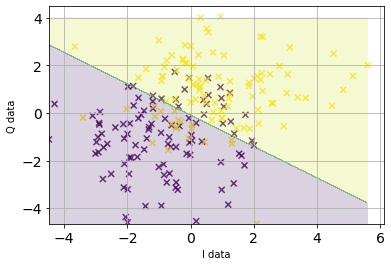

{'discriminator': LinearDiscriminantAnalysis(),
 'coef': array([[0.6444828 , 0.97807249]]),
 'intercept': array([0.09321996]),
 'score': 0.785,
 'success': True}

In [16]:
backend = DiscriminatorBackend()
exp = TwoLevelDiscriminator(1)
exp.set_analysis_options(discriminator_type="LDA")
exp_data = exp.run(backend, shots=100)
exp_data.block_for_results()
result = exp_data.analysis_results(0)
result_data = result.data()
# Print the result
display(exp_data.figure(0))
result_data

QDA classifier on the same data:

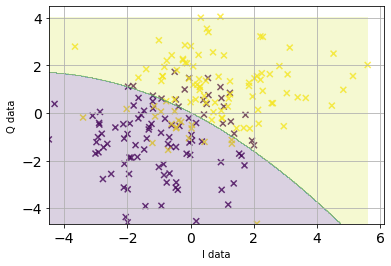

{'discriminator': QuadraticDiscriminantAnalysis(),
 'rotations': [array([[-0.74833745,  0.66331822],
         [-0.66331822, -0.74833745]]),
  array([[ 0.99831838,  0.05796911],
         [ 0.05796911, -0.99831838]])],
 'score': 0.775,
 'success': True}

In [10]:
backend = DiscriminatorBackend()
exp = TwoLevelDiscriminator(1)
exp.set_analysis_options(discriminator_type="QDA")
exp_data = exp.run(backend, shots=100)
exp_data.block_for_results()
result = exp_data.analysis_results(0)
result_data = result.data()
# Print the result
display(exp_data.figure(0))
result_data

## Run Discriminator Experiments in Parallel 

Multiple discriminators can be calibrated and analyzed at the same time using the parallel experiments framework. Note that unlike single experiments, parallel experiments need to have `MeasLevel` set to kerneled and `meas_return` set to single so that the data points returned are individual undiscriminated shots.

In [12]:
from qiskit_experiments.composite import ParallelExperiment

backend = DiscriminatorBackend()
par_exp = ParallelExperiment([TwoLevelDiscriminator(0), TwoLevelDiscriminator(1)])
par_exp.set_run_options(meas_level=MeasLevel.KERNELED, meas_return="single")
par_expdata = par_exp.run(backend, shots=1000)
par_expdata.block_for_results()
print(par_expdata)

---------------------------------------------------
Experiment: ParallelExperiment
Experiment ID: 20e877cf-6bda-4702-b581-57f6074bc76c
Status: DONE
Component Experiments: 2
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result:

Analysis Result: ParallelExperiment
Analysis Result ID: aca3a21e-d6c7-4bdd-b342-30bbe817a56e
Experiment ID: 20e877cf-6bda-4702-b581-57f6074bc76c
Device Components: [<Qubit(Q0)>, <Qubit(Q1)>]
Quality: None
Verified: False
Result Data:
- experiment_types: ['TwoLevelDiscriminator', 'TwoLevelDiscriminator']
- experiment_ids: ['69becc84-9fc5-4f6f-914b-bcfe5654a73a', '6d57eafe-f6f6-41cf-ab02-f8c1d57c3f83']
- experiment_qubits: [(0,), (1,)]
- success: True


## Use Data Processor Discriminator Node

---------------------------------------------------
Experiment: Discriminator
Experiment ID: 09df986a-26ed-45ea-bf22-65accf02ab8c
Status: DONE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: QuadraticDiscriminantAnalysis()
- rotations: [array([[-0.43811802,  0.89891746],
       [-0.89891746, -0.43811802]]), array([[-0.17039714,  0.98537547],
       [ 0.98537547,  0.17039714]])]
- score: 0.825
- success: True


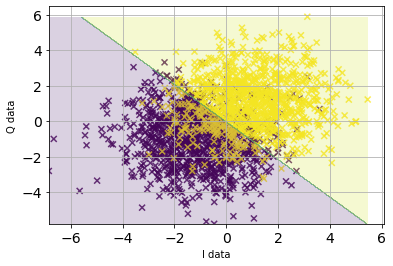

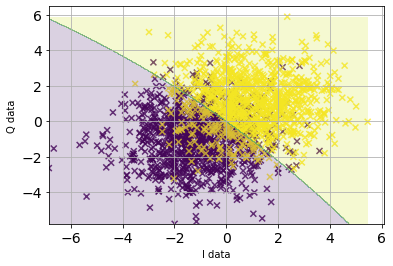

In [30]:
backend = DiscriminatorBackend()
exp = Discriminator(1)
exp.set_analysis_options(discriminator_type="LDA")
exp.set_run_options(meas_level=MeasLevel.KERNELED)
lda_res = exp.run(backend, shots=1024)
processor = DataProcessor("memory", [Discriminate(lda_res)])
processor.append(Probability("0"))
datum = processor(lda_res.data(0))

backend = DiscriminatorBackend()
exp2 = Discriminator(1)
exp2.set_analysis_options(discriminator_type="QDA")
exp2.set_run_options(meas_level=MeasLevel.KERNELED)
qda_res = exp2.run(backend, shots=1000)
qda_processor = DataProcessor("memory", [Discriminate(qda_res)])
qda_processor.append(Probability("0"))
print(qda_res)
datum = qda_processor(qda_res.data(0))

In [33]:
# LDA node
processor = DataProcessor("memory", [Discriminate(lda_res)])
processor.append(Probability("0"))
datum = processor(lda_res.data(0))
print(datum)

# QDA node
processor = DataProcessor("memory", [Discriminate(qda_res)])
processor.append(Probability("0"))
datum = processor(qda_res.data(0))

print(datum)

(0.8447265625, 0.011317660990670282)
(0.819, 0.012175343937647102)


Using a parallel experiment to discriminate over multiple qubits:

In [37]:
processor = DataProcessor("memory", [Discriminate(par_expdata)])
processor.append(Probability("01"))

datum = processor([par_expdata.data(0), par_expdata.data(1)])
print(datum)

(0.682, 0.014726710426975875)
